# Mouvement des Corps Rigides
## KIN-6839

### Rototrans dans biorbd

In [1]:
# Import needed packages
import biorbd    as brbd
import numpy     as np
import BiorbdViz as brbdv

In [4]:
# Load a simple model
b = brbdv.BiorbdViz(model_path="../../data/2boxes.bioMod")
# Play with it
b.set_q(np.array([1,0,0,np.pi/2,0,0,0,1,0,0,0,0]))
b.exec()

Note : biorbd's interface uses Euler angles. Look at the .bioMod file to find the corresponding sequence. Inside biorbd, rototrans are used, as seen during the class. Let's play a bit with these notions. 

In [3]:
# Code a function which takes a rototrans and outputs 6D vector of configuration
# Hints : 
# brbd.RotoTrans.toEulerAngles => <function biorbd.biorbd.RotoTrans.toEulerAngles(rt, seq)>
# brbd.object.to_array() => numpy array of the biorbd object
# np.hstack, np.vstack => horizontally or vertically stacks numpy arrays

def rt_to_config(rt) :
    eul   = brbd.RotoTrans.toEulerAngles(rt,'xyz')
    trans = rt.to_array()[:3,3] 
    return np.hstack([trans,eul.to_array()])


Test the function.

In [3]:
rt = brbd.RotoTrans()
print(f"Identity transform : \n {rt.to_array()}")
print(f"Equivalent coordinates : \n {rt_to_config(rt)}")

Identity transform : 
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
Equivalent coordinates : 
 [ 0.  0.  0. -0.  0. -0.]


Now, let's play with our boxes.
Build a rototrans matrix "rpz" for Rot(z,90°).
Build a rototrans matrix "rny" for Rot(y,-90°).

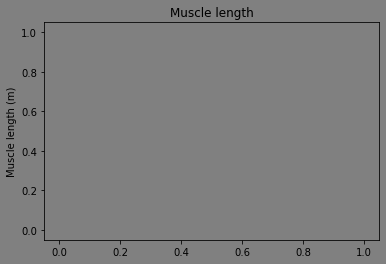

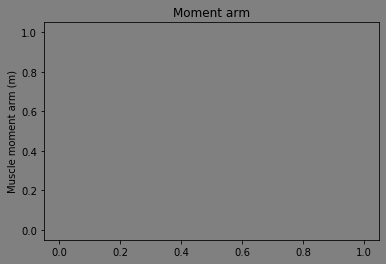

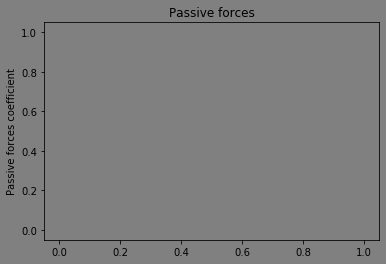

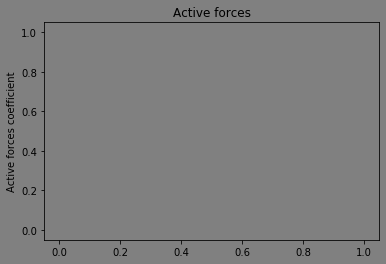

In [5]:
#rpz = brbd.RotoTrans(np.matrix([[0,-1,0,0],[1,0,0,0],[0,0,1,0],[0,0,0,1]]))
rpz = brbd.RotoTrans(np.matrix([[0,-1,0,0],[1,0,0,0],[0,0,1,0],[0,0,0,1]]))
rny = brbd.RotoTrans(np.matrix([[0,0,-1,0],[0,1,0,0],[1,0,0,0],[0,0,0,1]]))
rpz_config = rt_to_config(rpz)
rny_config = rt_to_config(rny)
b = brbdv.BiorbdViz(model_path="../../data/2boxes.bioMod")
b.set_q(np.hstack([rpz_config,rny_config]))

Test the product of rototrans, as seen in class. Visulalize the result in the viewer. Try to left and right multiply, discuss.

In [ ]:
###Code

### Rappels d'intégration numérique

Intégrer une fonction mathématique peut se faire analytiquement (formules connues, IPP, etc.) ou numériquement. 
Le principe de base de l'intégration numérique repose sur des appels à la fonction que l'on cherche à intégrer.

Coder la méthode des rectangles (Euler).
Comparer à la valeur analytique connue en faisant varier le pas d'intégration.

temps nécessaire : 2.4536256790161133
intégrale numérique = -0.49905180657145
intégrale exacte =  -0.5063656411097588


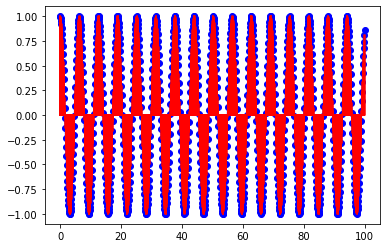

In [4]:
import matplotlib.pyplot as plt
from time import time

xmin = 0
xmax = 100
nbx = 1000
nbi = nbx - 1 # nombre d'intervalles

x = np.linspace(xmin, xmax, nbx)
y = np.cos(x)
plt.plot(x,y,"bo-")

integrale = 0
t = time()
for i in range(nbi):
    integrale = integrale + y[i]*(x[i+1]-x[i])
    # dessin du rectangle
    x_rect = [x[i], x[i], x[i+1], x[i+1], x[i]] # abscisses des sommets
    y_rect = [0   , y[i], y[i]  , 0     , 0   ] # ordonnees des sommets
    plt.plot(x_rect, y_rect,"r")
    
print("temps nécessaire :", time() - t)
print("intégrale numérique =", integrale)
print("intégrale exacte = ",np.sin(xmax))

plt.show()

Coder la méthode des trapèzes (Euler).
Comparer à la valeur analytique connue en faisant varier le pas d'intégration.

In [6]:
nbx = 1000
nbi = nbx - 1 # nombre d'intervalles

x = np.linspace(xmin, xmax, nbx)
y = np.cos(x)
plt.plot(x,y,"bo-")

integrale = 0
t = time()
for i in range(nbi):
    integrale = integrale + (y[i+1]+y[i])*(x[i+1]-x[i])/2
    # dessin du rectangle
    x_rect = [x[i], x[i], x[i+1], x[i+1], x[i]] # abscisses des sommets
    y_rect = [0   , y[i], y[i+1]  , 0     , 0   ] # ordonnees des sommets
    plt.plot(x_rect, y_rect,"r")
    
print("temps nécessaire :", time() - t)
print("intégrale numérique =", integrale)
print("intégrale exacte = ",np.sin(xmax))

plt.show()

temps nécessaire : 1.5310637950897217
intégrale numérique = -0.5059427539043958
intégrale exacte =  -0.5063656411097588


Lire d'autre méthodes d'intégration (Simpson, pôlynomes de Lagrange).
Utiliser l'intégration RK45 de scipy et comparer aux méthodes précédentes.

In [5]:
from scipy import integrate

def mycos(t,y):
    return np.cos(t)

t = time()
sol = integrate.solve_ivp(mycos, [xmin, xmax], [0], method='RK45')

print("temps nécessaire :", time() - t)
print("intégrale numérique =", -0.5060210157655309)
print("intégrale exacte = ",np.sin(xmax))


temps nécessaire : 0.029967308044433594
intégrale numérique = -0.5060210157655309
intégrale exacte =  -0.5063656411097588


### Retour aux corps rigides 

Intégrer une vitesse de rotation spatiale avec RK45. 
Comparer à la formule de Rodrigues.
Tracez l'erreur en degrés en fonction de la durée d'intégration.
Visualisez le résultat.

In [6]:
import math as math
from scipy import interpolate

T = 10*2*np.pi # Durée de la simulation
w = [1,1,1] # Axe de la rotation
w /= np.linalg.norm(w)

def so3(x):
    return np.array([[0, -x[2], x[1]],
                     [x[2], 0, -x[0]],
                     [-x[1], x[0], 0]])

def diff_R(t,R,w):
    dot_R = so3(w).dot(np.reshape(R,(3,3)))
    return np.reshape(dot_R,9)


func_ode = lambda t, R : diff_R(t,R,w)

R_0 = np.reshape(np.eye(3),9)
sol = integrate.solve_ivp(func_ode, [0, T], R_0, method='RK45')
sol_interp = interpolate.interp1d(sol.t,sol.y,kind='cubic')

print("intégrale numérique =", np.reshape(sol.y[:,-1],(3,3)))

def rodrigues(w,T):
    return np.eye(3)+np.sin(T)*so3(w) + (1-np.cos(T))*so3(w).dot(so3(w))
int_rod = rodrigues(w,T)
print("intégrale exacte = ", int_rod)

def rot_to_eul(rot):
    #psi   = math.atan2(rot[0,2],-rot[1,2])
    #theta = math.acos(max(-1, min(1, rot[2,2])))
    #phi   = math.atan2(rot[2,0],rot[2,1])
    theta = math.asin(max(-1, min(1, rot[0,2])))
    psi   = math.atan2(-rot[1,2] , rot[2,2])
    phi   = math.atan2(-rot[0,1] , rot[0,0])
    return np.array([psi,theta,phi])

eul_interp = []
interp_ratio = 1000
t_interp = np.linspace(0,T,interp_ratio)
for t in t_interp :
    eul_interp += [rot_to_eul(np.reshape(sol_interp(t),(3,3)))]

Ts = np.linspace(0,2000,num=20)
err = []
err_eul = []
for T in Ts :
    sol = integrate.solve_ivp(func_ode, [0, T], R_0, method='RK45')
    int_rod = rodrigues(w,T)
    err += [np.linalg.norm(np.reshape(sol.y[:,-1],(3,3))-int_rod)]
    err_eul += [np.abs(rot_to_eul(np.reshape(sol.y[:,-1],(3,3))) - rot_to_eul(int_rod))]

intégrale numérique = [[ 0.9989004  -0.00699435  0.00809396]
 [ 0.00809396  0.9989004  -0.00699435]
 [-0.00699435  0.00809396  0.9989004 ]]
intégrale exacte =  [[ 1.00000000e+00  1.41410032e-15 -1.41410032e-15]
 [-1.41410032e-15  1.00000000e+00  1.41410032e-15]
 [ 1.41410032e-15 -1.41410032e-15  1.00000000e+00]]


A présent, un petit exercice de présentation de résultat avec la librairie matplotlib.
Afficher sur une première figure le résultat de l'interpolation en angles d'Euler.

Sur une seconde figure, afficher deux graphiqueas : un pour l'erreur matricielle commise par RK45 et l'autre pour l'erreur correspondante en angles d'Euler.
Discuter.

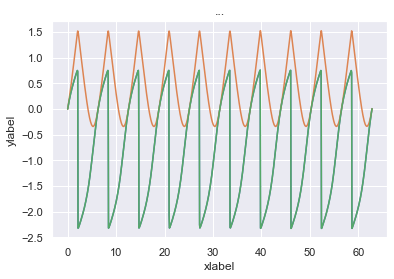

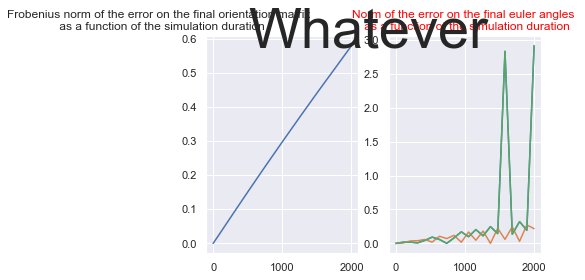

In [7]:
import seaborn as sns
sns.set()

plt.figure()
plt.plot(t_interp,eul_interp)
plt.xlabel("xlabel")
plt.ylabel("ylabel")
plt.title("...")

fig,(ax1,ax2) = plt.subplots(1,2)
ax1.plot(Ts,err)
ax1.set_title("Frobenius norm of the error on the final orientation matrix \n as a function of the simulation duration",x=-0.3)
ax2.plot(Ts,err_eul)
ax2.set_title("Norm of the error on the final euler angles \n as a function of the simulation duration",color=[1,0,0])
fig.suptitle("Whatever",fontsize=56)
plt.show()

Animer la sous biorbd-viz.

In [70]:
q_brbd = np.vstack([np.zeros((9,interp_ratio)),np.array(eul_interp).T])
b = brbdv.BiorbdViz(model_path="../data/2boxes.bioMod")
b.load_movement(q_brbd.T)
b.exec()

Pour les plus rapides, refaire la même analyse avec des rototrans.

In [ ]:
###Code

### Cinématique avec biorbd
Tester la cinématique d'une chaine avec biorbd.

In [82]:
b = brbdv.BiorbdViz(model_path="../data/robot.bioMod")
b.exec()

Envoyer des séquences d'angles aléatoires mais continues à biord-viz et constater le résultat de la cinématique directe appliquée à la chaîne.

In [16]:
nb_frames = 1000
angles = np.zeros((3,nb_frames))
for i in range(nb_frames-1) :
    angles[:,i+1] = angles[:,i] + 0.1*(np.random.rand(3)-0.4)
b = brbdv.BiorbdViz(model_path="../data/robot.bioMod")
b.load_movement(angles.T)
b.exec()

### Dynamique avec biorbd
Tester la dynamique de la chaîne : effectuer une simulation, la gravité est prise en compte par défaut dans les équations !

Écrire un programme rapide avec une intégration de type Euler.

Tracer la trajectoire du centre de masse.

In [54]:
m = brbd.Model("../data/robot.bioMod")
angles = np.zeros((3,nb_frames))
coms = np.zeros((3,nb_frames))
q  = np.zeros((3,))+0.01
dq = np.zeros((3,))
tau = np.zeros((3,))
dt=0.01
coms[:,0] = m.CoM(q).to_array()
angles[:,0] = q
for i in range(nb_frames-1) :
    ddq = m.ForwardDynamics(q,dq,tau)
    dq  += ddq.to_array()*dt
    q   += dq*dt
    angles[:,i+1] = q
    coms[:,i+1] = m.CoM(q).to_array()
b = brbdv.BiorbdViz(model_path="../data/robot.bioMod")
b.load_movement(angles.T)
b.exec()
plt.plot(coms[1,:],coms[2,:])
plt.title("CoM trajectory of a free falling triple pendulum")
plt.xlabel("$COM_y$")
plt.ylabel("$COM_z$")

Text(0, 0.5, '$COM_z$')

Recommencer avec RK45.

In [ ]:
###Code

Jouer avec les paramètres de la simulation, changer les paramètres inertiels, ajouter des couples articulaires, etc...

In [ ]:
###Code

Utiliser le modèle biorbd "robot_with_markers". Ce modèle inclut un marqueur au bout de chaque corps de la chaîne cinématique. 
Écrire une fonction qui calcule les positions 3D de ces marqueur, sachant q, la configuration du robot. 
Tracer les trajectoires de ces marqueurs pendant la simulation précédente.

In [66]:
m = brbd.Model("../data/robot_with_markers.bioMod")

def apply_rototrans_on_vec(rt,vec) :
    vec = np.concatenate((vec,np.array([1])))
    res = rt.dot(vec)
    return res[:3]

robot_markers = np.zeros((3,m.nbSegment()))
for i in range(m.nbSegment()) :
    robot_markers[:,i] = m.marker(i).to_array()
 
markers_traj = np.zeros((m.nbSegment(),3,nb_frames))
for i in range(nb_frames) :
    for j in range(m.nbSegment()) :
        gJCS = m.globalJCS(angles[:,i].T,j)
        markers_traj[j,:,i]   = apply_rototrans_on_vec(gJCS.to_array(),robot_markers[:,j])
print(markers_traj[:,1,:].shape)

plt.plot(markers_traj[0,1,:].T,markers_traj[0,2,:].T,'rx')
plt.plot(markers_traj[1:,1,:].T,markers_traj[1:,2,:].T)
plt.title("Markers trajectories of a free falling triple pendulum")
plt.xlabel("$Y ~coordinate$")
plt.ylabel("$Z ~coordinate$")

(4, 1000)


Text(22.097222222222214, 0.5, '$Z ~coordinate$')